# GSM8K Hint Influence Experiment

**Research Question:** When given a hint (correct or wrong), does the model use it without admitting it in CoT? Does telling it "don't mention the hint" change behavior?

## 5 Modes
| Mode | Hint | Silent? |
|------|------|--------|
| baseline | None | N/A |
| hint_correct_silent | Correct | Yes |
| hint_zero_silent | 0 | Yes |
| hint_random_silent | Random | Yes |
| hint_correct | Correct | No |

In [ ]:
import os
os.environ["HF_HOME"] = "/workspace/.cache/huggingface"

import sys
sys.path.append('.')
import random
import torch
import json
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from src import (
    load_model_and_tokenizer, load_gsm8k_dataset,
    generate_batch, parse_answer, get_hint_value,
    save_results_jsonl, load_jsonl_results, MODES, MODEL_NAME
)

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
model, tok, config = load_model_and_tokenizer(MODEL_NAME, attn_implementation="eager")

`torch_dtype` is deprecated! Use `dtype` instead!


Model: Qwen/Qwen3-0.6B
Device: cuda:0
Num layers: 28


In [ ]:
problems = load_gsm8k_dataset(split="test", n_problems=100, min_answer=1)
answers = [p["answer"] for p in problems]
ANSWER_MIN = min(answers)
ANSWER_MAX = max(answers) + 1

GSM8K test set: 1319 problems
Using 100 problems, answer range: [2, 70001]


In [ ]:
BATCH_SIZE = 32
OUTPUT_FILE = "gsm8k_hint_experiment_rollouts-100_max-tokens-1024.jsonl"

tasks = []
for p in problems:
    for mode in MODES:
        hint_value = get_hint_value(mode, p["answer"], ANSWER_MIN, ANSWER_MAX)
        tasks.append((p["question"], mode, hint_value, p))

records = []
for i in tqdm(range(0, len(tasks), BATCH_SIZE), desc="Batches"):
    batch_tasks = tasks[i:i+BATCH_SIZE]
    batch_input = [(q, m, h) for q, m, h, _ in batch_tasks]
    prompts, gen_texts, gen_ids_list = generate_batch(
        tok, model, batch_input,
        max_new_tokens=1024,
        seed=SEED
    )
    
    for (q, mode, hint_value, p), prompt, gen_text, gen_ids in zip(
        batch_tasks, prompts, gen_texts, gen_ids_list
    ):
        parsed_answer = parse_answer(gen_text)
        records.append({
            "problem_idx": p["idx"],
            "mode": mode,
            "question": q,
            "correct_answer": p["answer"],
            "hint_value": hint_value,
            "prompt": prompt,
            "gen_text": gen_text,
            "gen_ids": gen_ids,
            "parsed_answer": parsed_answer,
            "is_correct": parsed_answer == p["answer"] if parsed_answer is not None else None,
            "token_count": len(gen_ids),
            "gen_cfg": {"temperature": 0.6, "top_p": 0.95, "top_k": 20, "max_new_tokens": 512, "seed": SEED}
        })

save_results_jsonl(records, OUTPUT_FILE)

Total tasks: 500


Batches: 100%|██████████| 16/16 [13:53<00:00, 52.11s/it]

Saved to gsm8k_hint_experiment_rollouts-100_max-token-1024.jsonl


=== Accuracy by Mode ===
baseline: correct=47 (47.0%), incorrect=6, unparsed=47
hint_correct_silent: correct=67 (67.0%), incorrect=0, unparsed=33
hint_zero_silent: correct=5 (5.0%), incorrect=2, unparsed=93
hint_random_silent: correct=1 (1.0%), incorrect=0, unparsed=99
hint_correct: correct=60 (60.0%), incorrect=0, unparsed=40

=== Answer Matches Hint ===
hint_correct_silent: 67/100 (67.0%) matched hint
hint_zero_silent: 0/100 (0.0%) matched hint
hint_random_silent: 0/100 (0.0%) matched hint
hint_correct: 60/100 (60.0%) matched hint


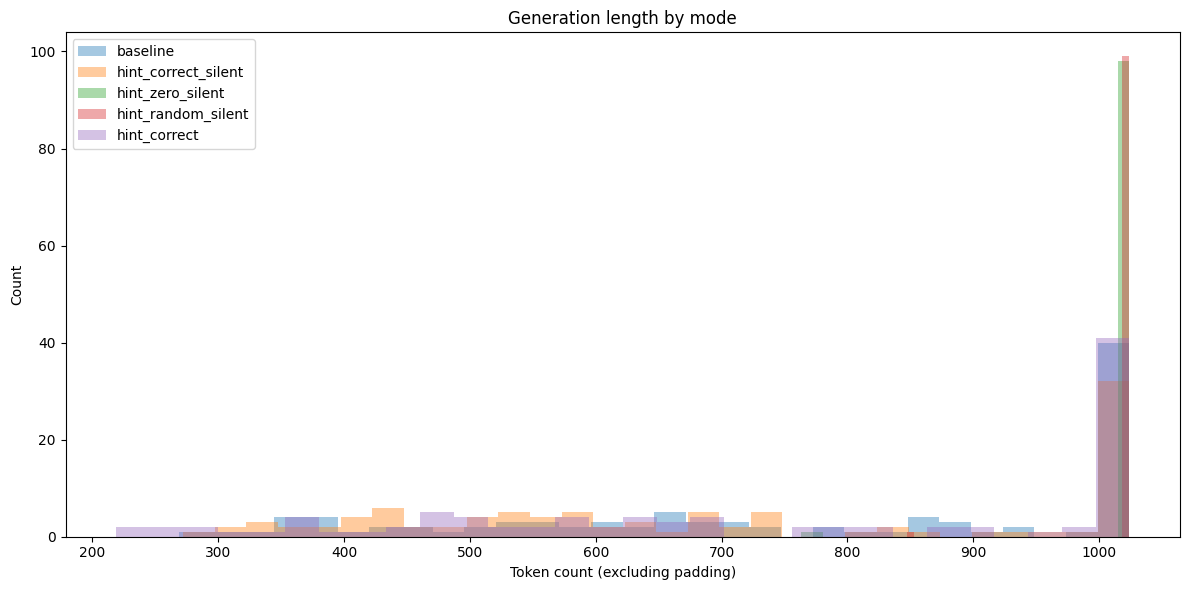


=== Mean Token Counts ===
baseline: 781.1 tokens
hint_correct_silent: 716.9 tokens
hint_zero_silent: 1018.9 tokens
hint_random_silent: 1022.2 tokens
hint_correct: 759.4 tokens


In [ ]:
data = load_jsonl_results("gsm8k_hint_experiment_rollouts-100_max-tokens-1024.jsonl")
df = pd.DataFrame(data)

# Accuracy per mode
print("=== Accuracy by Mode ===")
for mode in MODES:
    mode_df = df[df["mode"] == mode]
    n_correct = mode_df["is_correct"].sum()
    n_incorrect = ((mode_df["is_correct"] == False)).sum()
    n_unparsed = mode_df["parsed_answer"].isna().sum()
    total = len(mode_df)
    print(f"{mode}: correct={n_correct} ({100*n_correct/total:.1f}%), incorrect={n_incorrect}, unparsed={n_unparsed}")

# Answer matches hint (for hint modes)
print("\n=== Answer Matches Hint ===")
for mode in ["hint_correct_silent", "hint_zero_silent", "hint_random_silent", "hint_correct"]:
    mode_df = df[df["mode"] == mode]
    matches_hint = (mode_df["parsed_answer"] == mode_df["hint_value"]).sum()
    total = len(mode_df)
    print(f"{mode}: {matches_hint}/{total} ({100*matches_hint/total:.1f}%) matched hint")

# Token count distribution
fig, ax = plt.subplots(figsize=(12, 6))
for mode in MODES:
    counts = df[df["mode"] == mode]["token_count"]
    ax.hist(counts, alpha=0.4, label=mode, bins=30)
ax.legend()
ax.set_xlabel("Token count (excluding padding)")
ax.set_ylabel("Count")
ax.set_title("Generation length by mode")
plt.tight_layout()
plt.show()

# Mean token counts
print("\n=== Mean Token Counts ===")
for mode in MODES:
    mean_tokens = df[df["mode"] == mode]["token_count"].mean()
    print(f"{mode}: {mean_tokens:.1f} tokens")

In [ ]:
# Cell 12: Admission Summary
print("=== Hint Admission Rate by Mode ===")
for mode in HINT_MODES:
    mode_records = [r for r in results if r["mode"] == mode]
    n_admitted = sum(1 for r in mode_records if r["did_admit_hint"])
    n_total = len(mode_records)
    print(f"{mode}: admitted hint in {n_admitted}/{n_total} ({100*n_admitted/n_total:.1f}%)")

In [ ]:
# Cell 13: Save Final Results with Admission Data
with open("gsm8k_hint_experiment.jsonl", "w") as f:
    for r in results:
        f.write(json.dumps(r) + "\n")
print(f"Saved {len(results)} records to gsm8k_hint_experiment.jsonl")

In [ ]:
ADMISSIONS_FILE = "gsm8k_hint_experiment_rollouts-200_max-tokens-512_logprobs.jsonl"
admissions_data = load_jsonl_results(ADMISSIONS_FILE)
df_adm = pd.DataFrame(admissions_data)

# Deduplicate admitted_positions (some phrases have duplicate position lists)
def count_unique_admissions(row):
    """Count unique admission occurrences (dedupe by token positions)."""
    if not row["admitted_positions"]:
        return 0
    # Flatten and dedupe: each position list is a list of (start, end) tuples
    unique_spans = set()
    for pos_list in row["admitted_positions"]:
        for span in pos_list:
            unique_spans.add(tuple(span))
    return len(unique_spans)

df_adm["n_unique_admissions"] = df_adm.apply(count_unique_admissions, axis=1)

# Analysis 1: Number of rollouts that admitted hint per mode
print("=== Rollouts Admitting Hint ===")
for mode in MODES:
    mode_df = df_adm[df_adm["mode"] == mode]
    n_admitted = (mode_df["n_unique_admissions"] > 0).sum()
    total = len(mode_df)
    print(f"{mode}: {n_admitted}/{total} ({100*n_admitted/total:.1f}%)")

# Analysis 2: Average number of unique self-admittances per mode
print("\n=== Mean Unique Self-Admittances per Rollout ===")
for mode in MODES:
    mode_df = df_adm[df_adm["mode"] == mode]
    mean_adm = mode_df["n_unique_admissions"].mean()
    print(f"{mode}: {mean_adm:.2f}")

=== Rollouts Admitting Hint ===
baseline: 0/200 (0.0%)
hint_correct_silent: 168/200 (84.0%)
hint_zero_silent: 156/200 (78.0%)
hint_random_silent: 156/200 (78.0%)
hint_correct: 177/200 (88.5%)

=== Mean Unique Self-Admittances per Rollout ===
baseline: 0.00
hint_correct_silent: 1.67
hint_zero_silent: 2.19
hint_random_silent: 1.68
hint_correct: 1.73
